In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, version=1)
mnist.keys()

X, y = mnist['data'], mnist['target']

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

import numpy as np
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# 교차 검증을 사용한 정확도 측정
가끔 사이킷런이 제공하는 것보다<br>
교차 검증 과정을 더 많이 제어해야 할 필요가 있습니다.

이 때는 교차 검증 기능을 직접 구현하면 됩니다.

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [3]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- sklearn.model_selection.StratifiedKFold: This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
- sklearn.base.clone: returns a new estimator with the same parameters that has not been fitted on any data.

그런데 더 사이킷런이 제공하는 정도로만 제어를 하면 된다면<br>
그냥 제공하는 걸 쓰는 게 더 좋은 방법이라 할 수 있겠습니다.

In [4]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95% 이상인 것을 볼 수 있습니다.

이게 되게 좋아보일 수 있는데,<br>
모든 이미지를 '5 아님'클래스로 분류하는 더미 분류기를 만들어서 비교해보겠습니다.

In [5]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [6]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

어떤 이미지인지 보지도 않고 전부 다 '5 아님' 클래스로 분류했는데도<br>
정확도가 90% 이상이 나옵니다.

전체 이미지 중 10% 정도만 5일 것이기 때문에<br>
무조건 '5 아님' 으로 예측하면 정확히 맞출 확률이 90%입니다.

이 예제는 정확도를 분류기를 성능 측정 지표로 선호하지 않는 이유를 보여줍니다.<br>
특히 불균형한 데이터셋을 다룰 때 더욱 그렇습니다.

# 오차 행렬
분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것입니다.

이 방법은 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 방법입니다.<br>
예를 들어서 분류기가 숫자 5를 3으로 잘못 분류한 횟수를 알고 싶다면<br>
오차 행렬의 5행 3열을 보면 됩니다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있게 먼저 예측값을 만들어야 합니다.<br>
이 때 cross_val_predict() 함수를 사용할 수 있습니다.

- sklearn.model_selection.cross_val_predict: cross_val_score 함수처럼 k-겹 교차 검증을 수행하는데 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환합니다.

In [7]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

이제 confusion_matrix() 함수를 사용해 오차 행렬을 만들 준비가 됐습니다.<br>
함수에 타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출하면 됩니다.

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 실제 클래스를 나타내고,<br>
오차 행렬의 열은 예측한 클래스를 나타냅니다.

이 행렬의 첫 번째 행은 '5 아님' 이미지(음성 클래스)에 대한 것으로,<br>
1행 1열의 수는 '5 아님' 이미지를 '5 아님' 이미지로 정확하게 분류(진짜 음성)한 수를 나타내고,<br>
1행 2열의 수는 '5 아님' 이미지를 '5' 이미지로 틀리게 분류(거짓 음성)한 수를 나타냅니다.

이 행렬의 두 번째 행은 '5' 이미지(양성 클래스)에 대한 것으로,<br>
2행 1열의 수는 '5' 이미지를 '5 아님' 이미지로 틀리게 분류(거짓 양성)한 수를 나타내고,<br>
2행 2열의 수는 '5' 이미지를 '5' 이미지로 정확하게 분류(진짜 양성)한 수를 나타냅니다.

완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로<br>
오차 행렬의 주대각선만 0이 아닌 값이 됩니다.

In [9]:
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# 정밀도와 재현율
오차 행렬이 많은 정보를 제공해주지만 더 요약된 지표도 필요할 수 있습니다.

그 중 하나가 양성 예측의 정확도입니다. 이를 분류기의 정밀도 라고 합니다.

\\[ \displaystyle precision = \frac{TP}{TP + FP}, \hbox{ TP: true positive, FP: false positive} \\]

정밀도는 재현율 이라는 또 다른 지표와 같이 사용하는 것이 일반적입니다.<br>
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로,<br>
민감도 또는 진짜 양성 비율 이라고도 합니다.

\\[ \displaystyle recall = \frac{TP}{TP + FN}, \hbox{ TP: true positive, FN: false negative} \\]

사이킷런은 정밀도와 재현율을 포함해 분류기의 지표를 계산하는 여러 함수를 제공합니다.<br>
그 중 이번에 얘기한 정밀도를 구해주는 precision_score 함수와<br>
재현율을 구해주는 recall_score 함수를 살펴보겠습니다.

In [10]:
from sklearn.metrics import precision_score, recall_score

In [11]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

5로 판별된 이미지 중 어느 정도가 정확한지 알 수 있습니다.

In [12]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

전체 5 중 얼마나 제대로 감지했는지 알 수 있습니다.

정밀도와 재현율을 \\(F_{1} \hbox{ score}\\)라고 하는 하나의 숫자로 만들면 편리할 때가 많습니다.<br>
이 점수는 정밀도와 재현율의 조화 평균 입니다.

\\[ \displaystyle F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} \\]

이 점수를 계산하려면 f1_score 함수를 사용하면 됩니다.

In [13]:
from sklearn.metrics import f1_score

In [14]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 \\(F_{1} \hbox{ score}\\)가 높습니다.<br>
하지만 이게 항상 바람직한 것은 아니고,<br>
상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있습니다.

이 둘을 모두 얻을 수는 없습니다.<br>
정밀도를 올리면 재현율이 줄고,<br>
재현율을 올리면 정밀도가 줄어듭니다.

이러한 관계를 정밀도/재현율 트레이드오프 라고 합니다.

# 정밀도/재현율 트레이드오프
SGDClassifier가 분류를 어떻게 결정하는지 살펴보며<br>
정밀도/재현율 트레이드오프를 이해해보겠습니다.

이 분류기는 결정 함수를 사용해서 각 샘플에 대해 점수를 계산합니다.<br>
이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고,<br>
그렇지 않으면 음성 클래스에 할당합니다.

임곗값을 줄이면 양성 클래스라고 판단하는 기준이 완화되는 것이고,<br>
더 많은 가짜 양성이 생길 것이고,<br>
진짜 양성들은 진짜 양성으로 분류될 확률이 높아지는 것입니다.

다시 말하면, 정밀도가 낮아지고 재현율이 높아지는 것입니다.

반대로 임곗값을 늘리면 양성 클래스라고 판단하는 기준이 강화되는 것이고,<br>
가짜 양성이 줄 것이고,<br>
진짜 양성들 중 진짜 양성으로 분류되지 않은 샘플들이 많아질 것입니다.

이건 다시 말하면, 정밀도가 높아지고 재현율이 낮아지는 것입니다.

사이킷런에서 임곗값을 직접 정할 순 없지만 예측에 사용한 점수는 확인할 수 있습니다.<br>
분류기의 decision_function() 메소드를 호출하면 각 샘플의 점수를 알 수 있습니다.<br>
이 점수를 기반으로 원하는 임겟값을 정해 예측을 만들 수 있습니다.

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [17]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임곗값을 정하기 위해서는<br>
먼저 cross_val_predict() 함수를 사용해 훈련 세트의 모든 샘플의 점수를 구해야 합니다.<br>
이번에는 예측 결과가 아니라 결정 점수를 반환받도록 method='decision_function'으로 정해줘야 합니다.

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

이렇게 얻은 점수로 precision_recall_curve() 함수를 이용해 모든 임곗값에 대해<br>
정밀도와 재현율을 계산할 수 있습니다.

In [19]:
from sklearn.metrics import precision_recall_curve

In [20]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [21]:
thresholds.shape

(59966,)

이제 matplotlib을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있습니다.

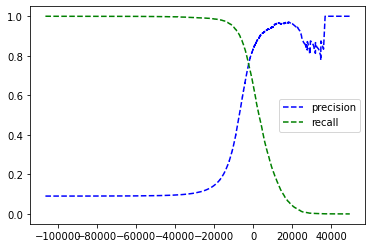

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

아래와 같이 재현율에 대한 정밀도 곡선을 그리는 방법도 있습니다.

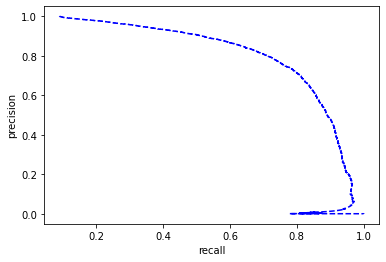

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions, recalls, 'b--')
    plt.xlabel('recall')
    plt.ylabel('precision')

plot_precision_vs_recall(precisions, recalls)
plt.show()

재현율 80% 근처에서 정밀도가 급격히 주는 것을 볼 수 있습니다.<br>
이 하강점 직전을 트레이드오프로 선택하는 것이 좋습니다.<br>
물론 이런 선택은 프로젝트마다 다르므로 상황에 맞춰 선택하는 것이 옳습니다.

여기서 정밀도 90%를 달성하는 것이 목표라면 아래와 같이 threshold를 정해줄 수 있습니다.

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [26]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC 곡선
수신기 조작 특성(ROC) 곡선도 이진 분류에서 널리 사용하는 도구입니다.

이 곡선은 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선입니다.

양성으로 잘못 분류된 음성 샘플의 비율이 FPR입니다.<br>
FPR은 1에서 진짜 음성 비율(TNR)을 뺀 값입니다.

TNR을 특이도라고도 합니다.<br>
따라서 ROC 곡선은 민감도(재현율)에 대한 1 - 특이도 그래프입니다.

ROC 곡선을 그리려면 roc_curve() 함수를 사용해<br>
여러 임곗값에서 TPR과 FPR을 계산해야 합니다.

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

이제 이를 이용해 TPR에 대한 FPR 곡선을 그릴 수 있습니다.

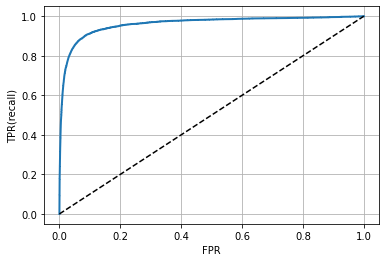

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR(recall)')
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

여기에서도 트레이드오프가 있습니다.<br>
재현율이 높을수록 거짓 양성이 늘어납니다.

점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻합니다.<br>
좋은 분류기는 이 점선에서 최대한 멀리 떨어져있어야 합니다.

곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있습니다.<br>
완벽한 분류기는 ROC의 AUC가 1이고,<br>
완전한 램덤 분류기는 AUC가 0.5입니다.

사이킷런은 ROC의 AUC를 계산하는 함수를 제공합니다.

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜서 SGDClassifier의 ROC 곡선과 AUC 점수를 비교해보겠습니다.<br>
이를 위해서 훈련 세트의 샘플에 대한 점수를 얻어야 하는데,<br>
작동 방식의 차이 때문에 RandomForestClassifier는 decision_function() 대신 predict_proba()가 있습니다.

predict_proba는 샘플이 행, 클래스가 열이고,<br>
샘플이 각 클래스에 속할 확률을 담은 배열을 반환합니다.

사이킷런 분류기는 일반적으로 이 둘 중 하나 또는 둘 다를 가지고 있습니다.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [34]:
y_scores_forest = y_probas_forest[:, 1]  # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

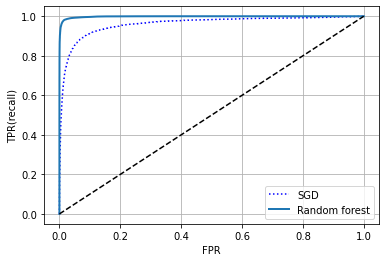

In [35]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random forest')
plt.legend(loc='lower right')
plt.show()

위 그래프를 보면 SGD보다 RandomForestClassifier의 ROC 곡선이 훨씬 더 좋아 보입니다.<br>
당연히 ROC AUC 점수도 훨씬 높습니다.

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

정밀도와 재현율 점수도 훨씬 높습니다.

In [37]:
y_train_pred_forest = y_scores_forest > 0.5

In [38]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [39]:
recall_score(y_train_5 ,y_train_pred_forest)

0.8662608374838591